In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve,root_scalar,minimize
from scipy.integrate import solve_ivp,quad

In [3]:
plt.rcParams.update({
    "text.usetex": True,             # Use LaTeX for all text rendering
    "font.family": "serif",          # Use a serif font like Computer Modern
    "font.serif": ["Computer Modern"],
    "font.size": 10,                 # General font size (matches LaTeX \normalsize for 11pt)
    "axes.labelsize": 10,            # Font size for axis labels
    "axes.titlesize": 10,            # Font size for plot titles
    "legend.fontsize": 7,            # Font size for legends
    "xtick.labelsize": 7,            # Font size for x-tick labels
    "ytick.labelsize": 7,            # Font size for y-tick labels
    "axes.linewidth": 1,             # Line width for axes
    "lines.linewidth": 1,            # Line width for plot lines
    "patch.linewidth": 1,           # Line width for patches
    "figure.titlesize": 10
})

In [4]:
# scalings
L=1e5;g=9.81; m = 80; P_peloton_hat = 200 # Watts
rho = 1.225; A= 0.36;C_d_avg = 0.7
v_hat_peloton = (2*P_peloton_hat/(C_d_avg*rho*A))**(1/3)
print(v_hat_peloton*3.6) #kph
gravity_term = m*g*v_hat_peloton/P_peloton_hat
print(gravity_term)
acceleration_term = m*v_hat_peloton**3/L/P_peloton_hat
print(acceleration_term)
peloton_time = L/v_hat_peloton
print(peloton_time/3600) # hours
energy_scale = P_peloton_hat*peloton_time
print(energy_scale/4184)#kcal
omega = 0.5
lambda_ = 0.25
N_0 = 5
zeta_0_hat = N_0*4
zeta_0 = zeta_0_hat/L
print(zeta_0)
P_lurking = (0.05 + (1-0.05)*np.exp(-lambda_*zeta_0*L/4))/0.7

print(P_lurking)
C_d_single=1/0.7
print(C_d_single)
#plt.plot(np.linspace(0,1,100), theta(np.linspace(0,1,100)))
def C_d(zeta):
    if zeta > 0:
        return (0.05 + (1-0.05)*np.exp(-zeta*L/4*lambda_))/0.7 # you are inside the peloton
    elif zeta > 0.001:
        return 1/0.7 # you have fallen behind the peloton and you are by yourself
    else:
        return 1/0.7 # you are ahead of the peloton
C_d_lurking = C_d(zeta_0)
print(C_d_lurking)
prob_crash = 2
P_stable = P_lurking
N = 75
print(prob_crash/N)
mu = 1

39.247345458971374
42.77960655027881
0.005183025591188855
2.5479430221475385
438.46055830454776
0.0002
0.46025651002454365
1.4285714285714286
0.46025651002454365
0.02666666666666667


/var/folders/wx/hvlspwk90qj6x4ybxggkjycr0000gn/T/ipykernel_1821/2356412838.py:21: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  finish_time = fsolve(f,T_f_easy,xtol = 1e-9)
/var/folders/wx/hvlspwk90qj6x4ybxggkjycr0000gn/T/ipykernel_1821/2356412838.py:21: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  finish_time = fsolve(f,T_f_easy,xtol = 1e-9)


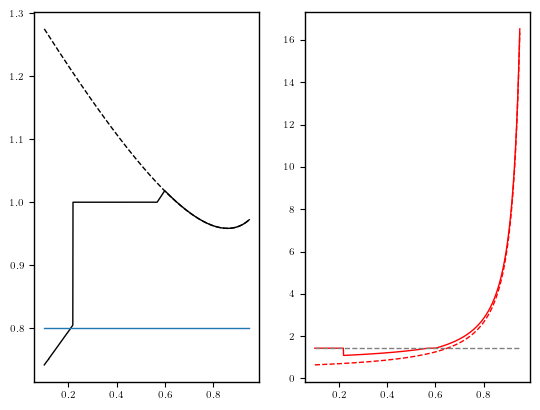

In [5]:
E_ast = 0.8

def find_P_max(finish_time, x_attack, E_ast, P_stable, P_lurking, mu):
    return P_lurking + mu * (E_ast - P_lurking*finish_time)/(1-np.exp(-mu*(finish_time-x_attack)))
def find_finish_time(x_attack, E_ast, P_stable, P_lurking, mu, C_d_single):
    def f(finish_time):
        P_max = find_P_max(finish_time,x_attack, E_ast, P_stable, P_lurking, mu)
        if P_max < C_d_single:
            return 1
        
        t = np.linspace(x_attack, finish_time, 100).T

        integrand = (P_stable + (P_max - P_stable) * np.exp(-mu * (t - x_attack))) ** (1 / 3)


        integral = np.trapz(integrand, t)

        return (integral / C_d_single**(1/3)) + x_attack - 1
    T_f_easy = x_attack+(1-x_attack)**(3/2)*C_d_single**(1/2)/(E_ast-C_d_lurking*x_attack)**(1/2)
    T_f_easy = np.where(T_f_easy <1, T_f_easy, 1)
    finish_time = fsolve(f,T_f_easy,xtol = 1e-9)
    #finish_time = root_scalar(f, bracket=[0, 10], method='bisect', xtol=1e-6)
    return finish_time[0]
def energy_computation(finish_time,P_max, x_attack,P_stable, P_lurking, mu):
    return P_lurking*finish_time+(P_max-P_lurking)*(1-np.exp(-mu*(finish_time-x_attack)))/mu
find_finish_time(0.6, 1.1, P_stable, P_lurking, mu, C_d_single)
x_attack_vec = np.linspace(0.1, 0.95, 1000)
finish_time_vec = np.zeros_like(x_attack_vec)
P_max_vec = np.zeros_like(x_attack_vec)
energy_vec = np.zeros_like(x_attack_vec)
for j,x_attack in enumerate(x_attack_vec):
    finish_time =find_finish_time(x_attack, E_ast, P_stable, P_lurking, mu, C_d_single)
    finish_time_vec[j] = finish_time 
    P_max_vec[j] = find_P_max(finish_time,x_attack, E_ast, P_stable, P_lurking, mu)
    energy_vec[j] = energy_computation(finish_time,P_max_vec[j], x_attack, P_stable, P_lurking, mu)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(x_attack_vec, finish_time_vec,color='black')
T_f_easy = x_attack_vec+(1-x_attack_vec)**(3/2)*C_d_single**(1/2)/(E_ast-C_d_lurking*x_attack_vec)**(1/2)
ax[0].plot(x_attack_vec, T_f_easy,
           '--',color='black')
ax[0].plot(x_attack_vec,energy_vec)
plt.plot(x_attack_vec, P_max_vec,color='red')
plt.plot(x_attack_vec, ((E_ast-P_lurking*x_attack_vec)/(1-x_attack_vec)/C_d_single**(1/3))**(3/2),'--',color='red')
plt.plot(x_attack_vec,np.ones_like(x_attack_vec)*C_d_single,'--',color='grey')

In [5]:
def objective(x, beta, omega):
    T_f, T_a, P_max = x
    term1 =  np.where((T_f - 1)<0, T_f-1, 0)
    N_0=5
    term2 = (1 - T_a + T_a * (1 - np.exp(-omega * N_0)) / (1 - np.exp(-omega)))*prob_crash/N
    term2 = T_a * (1 - np.exp(-omega * N_0)) / (1 - np.exp(-omega))*prob_crash/N
    term2 += (1-T_a)*prob_crash/N*np.where((T_f - 1)<0, 1, 0)
    term2 += (1-T_a)*prob_crash/N*np.where((T_f - 1)<0, 0, 1)* (1 - np.exp(-omega * N_0)) / (1 - np.exp(-omega))
    return beta*term1 + term2*(1-beta)

def constraint1(x, mu, P_s, C_d_single):
    """This solve x(T_f)=1 for T_F"""
    T_f, T_a, P_max = x
    integrand = lambda tau: (P_s + (P_max - P_s) * np.exp(-mu * (tau - T_a))) ** (1/3)
    integral, _ = quad(integrand, T_a, T_f)
    return T_a + (1 / C_d_single ** (1/3)) * integral - 1

def constraint2(x, E, P_l, P_s, mu):
    """This solves the energy equation for the power-T_f relationship"""
    T_f, T_a, P_max = x
    term1 = P_l * T_a
    term2 = P_s * (T_f - T_a)
    term3 = (1 / mu) * (1 - np.exp(-mu * (T_f - T_a))) * (P_max - P_s)
    return term1 + term2 + term3 - E

def solve_optimization(E, beta, mu, omega, P_l, P_s, C_d):
    # Initial guess for T_f, T_a, P_max
    x0 = np.array([1.0, 0.5, 10.0])

    # Constraints
    cons = [
        {'type': 'eq', 'fun': constraint1, 'args': (mu, P_s, C_d)},
        {'type': 'eq', 'fun': constraint2, 'args': (E, P_l, P_s, mu)}
    ]

    # Bounds (if any)
    bounds = [(0.5, None), (0,1.1), (0.4, None)] # bound the attack time to within the race

    # Solve
    result = minimize(objective, x0, args=(beta, omega), constraints=cons, bounds=bounds)
    return result

  message: A termination event occurred.
  success: True
   status: 1
        t: [ 0.000e+00  2.002e-03 ...  9.209e-01  9.229e-01]
        y: [[ 0.000e+00  2.002e-03 ...  9.982e-01  9.998e-01]]
      sol: None
 t_events: [array([ 9.232e-01])]
 y_events: [array([[ 1.000e+00]])]
     nfev: 107
     njev: 0
      nlu: 0
0.9232108645105299


1.3781363423858957

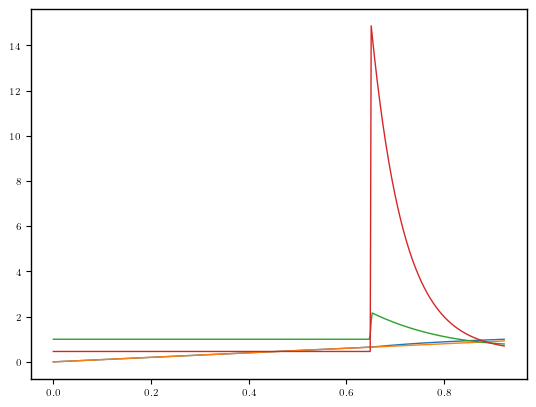

In [6]:
def stop_condition(t,state_vec):
        return state_vec[0]-1
stop_condition.terminal = True

def power(t,x_attack,  P_max,mu, P_stable=P_stable, P_lurking=P_lurking):
    return np.where(t<x_attack, P_lurking, P_stable + (P_max - P_stable) * np.exp(-mu * (t - x_attack)))
def compute_E(x_attack, T_f,P_max, mu, P_l=P_lurking, P_s=P_stable):
    T_a = x_attack
    term1 = P_l * T_a
    term2 = P_s * (T_f - T_a)
    term3 = (1 / mu) * (1 - np.exp(-mu * (T_f - T_a))) * (P_max - P_s)
    #return P_l * T_a + P_max * (T_f - T_a)
    return term1 + term2 + term3 

def find_finish_time(x_attack, P_max,mu, P_stable=P_stable, P_lurking=P_lurking,C_d_single=C_d_single, plot=False):
    tol = 1E-7
    def RHS(t,state_vec):
        x = state_vec[0]
        if x < x_attack:
            v = 1
        else:
            v = (P_stable + (P_max - P_stable) * np.exp(-mu * (t - x_attack))) ** (1/3)/C_d_single**(1/3)
            #v = (P_max/C_d_single)**(1/3)
        if x < t-1E-10:
            # rider has been overtaken by the peloton, they simply rejoin
            v = 1
        return np.array([v])
    ic = np.array([0])
    t_span = (0, 2)
    t_eval = np.linspace(0, 2, 1000)
    sol = solve_ivp(RHS, t_span, ic, t_eval=t_eval, method='LSODA', events=stop_condition,rtol=tol)
    if plot:
        plt.plot(sol.t, sol.y[0,:])
        plt.plot(sol.t,sol.t)
        plt.plot(sol.t, np.gradient(sol.y[0,:],sol.t))
        plt.plot(sol.t, power(sol.t,x_attack, P_max, mu))
        print(sol)

    return sol.t_events[0][0]
x_attack, P_max = 0.65,15
mu = 15
T_f = find_finish_time(x_attack, P_max, mu, P_stable=P_stable, P_lurking=P_lurking,C_d_single=C_d_single,plot=True)
print(T_f)
compute_E(x_attack,T_f, P_max, mu, P_l=P_lurking, P_s=P_stable)

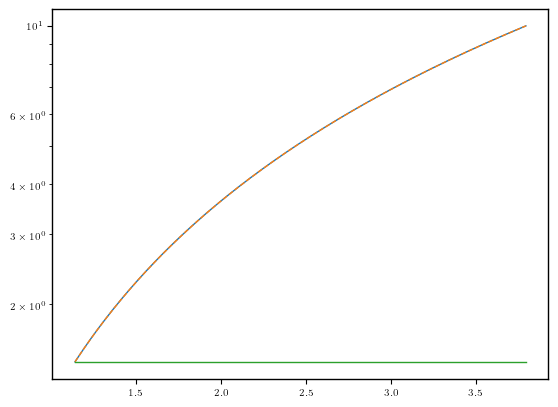

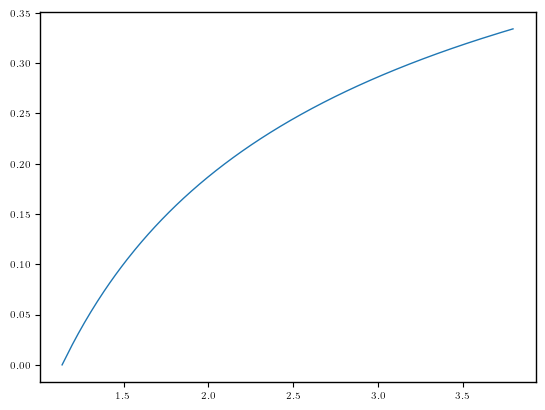

In [140]:
P_max_vec = np.linspace(P_lurking, 10, 100)
P_attack_min = C_d_single
P_max_vec = np.logspace(np.log10(P_attack_min)+1E-10, 1, 200)
E_ast_vec = np.zeros_like(P_max_vec)
T_f_vec = np.zeros_like(P_max_vec)
mu = 1E-3
x_attack = 0.3
for j,P_max in enumerate(P_max_vec):
    if P_max > C_d_single:
        T_f = find_finish_time(x_attack, P_max, mu, P_stable=P_stable, P_lurking=P_lurking,C_d_single=C_d_single )
        E_ast_vec[j] = compute_E(x_attack,T_f, P_max, mu, P_l=P_lurking, P_s=P_stable)
        T_f_vec[j]=T_f
    else:
        T_f = 1
        E_ast_vec[j] =  x_attack*P_lurking + (1-x_attack)*P_max

plt.semilogy(E_ast_vec, P_max_vec)
P_max_simple = ((E_ast_vec-P_lurking*x_attack)/(C_d_single**(1/3)*(1-x_attack)))**(3/2)
plt.plot(E_ast_vec,P_max_simple,'--')

plt.plot(E_ast_vec, np.ones_like(E_ast_vec)*P_attack_min)
plt.show()
plt.plot(E_ast_vec, 1-T_f_vec)


In [112]:
P_max_vec = np.logspace(np.log10(P_attack_min), 1,50)
x_attack_vec = np.linspace(0.01, 0.99, 200,endpoint=True)
E_ast_array = np.zeros((len(x_attack_vec), len(P_max_vec)))
T_f_vec = np.zeros((len(x_attack_vec), len(P_max_vec)))

mu = 0.01
for i, x_attack in enumerate(x_attack_vec):
    for j,P_max in enumerate(P_max_vec):
        T_f_vec[i,j] = find_finish_time(x_attack, P_max, mu, P_stable=P_stable, P_lurking=P_lurking)
        E_ast_array[i,j] = compute_E(x_attack,T_f, P_max, mu, P_l=P_lurking, P_s=P_stable)


0.99


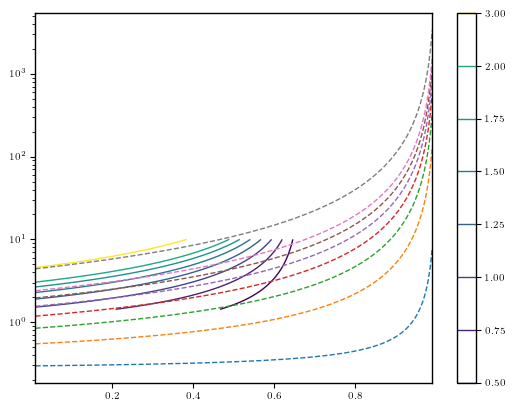

In [116]:
levels = [0.5,0.75, 1.0,1.25,1.5,1.75,2.0,3.0]

contour = plt.contour(x_attack_vec, P_max_vec, E_ast_array.T, levels=levels)
print(x_attack_vec[-1])
for j, E_ast in enumerate(levels):
    plt.plot(x_attack_vec, ((E_ast-P_lurking*x_attack_vec)/(1-x_attack_vec)/C_d_single**(1/3))**(3/2),'--')
plt.yscale('log')
plt.colorbar()

(0.0, 1.0)

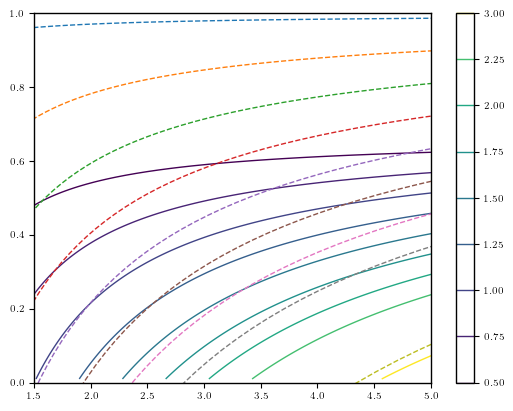

In [119]:
levels = [0.5,0.75, 1.0,1.25,1.5,1.75,2.0,2.25,3.0]

contour = plt.contour(P_max_vec,x_attack_vec, E_ast_array, levels=levels)

for j, E_ast in enumerate(levels):
    plt.plot(P_max_vec, (C_d_single**(1/3)*P_max_vec**(2/3)-E_ast)/(C_d_single**(1/3)*P_max_vec**(2/3)-C_d_lurking),'--')
plt.colorbar()
plt.xlim([1.5,5])
plt.ylim([0,1])

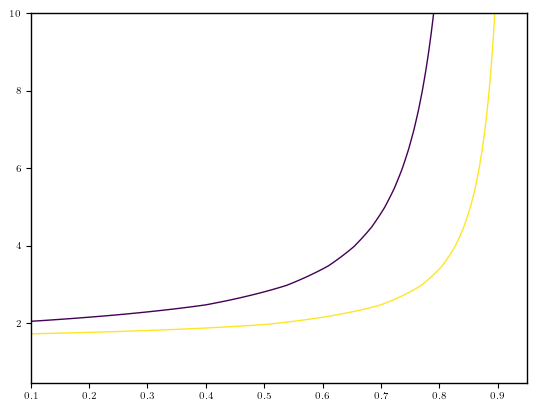

In [172]:
plt.contour(x_attack_vec, P_max_vec, T_f_vec.T, levels=[0.9,0.95] )